<a href="https://colab.research.google.com/github/mkeohane01/GAN-Image-Denoising/blob/main/notebooks/fastAI_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI GAN

In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *
from PIL import ImageDraw, ImageFont
import os
import shutil
from fastai.vision.learner import unet_learner
from fastai.vision.all import *
from fastai.vision.models.unet import *
from sklearn.model_selection import train_test_split
from math import log10, sqrt
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

## Import data

Import the data and format it.

In [21]:
colab = True
if colab == True:
    !pip install kaggle
    from google.colab import files
    files.upload()

    # Download kaggle dataset
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/

    # Small dataset
    !kaggle datasets download -d rajat95gupta/smartphone-image-denoising-dataset


Saving kaggle.json to kaggle.json
100% 6.16G/6.16G [01:17<00:00, 143MB/s]
100% 6.16G/6.16G [01:17<00:00, 85.7MB/s]


In [22]:
# Unzip the smartphone denoising dataset
if colab == True:
    !unzip '/content/smartphone-image-denoising-dataset.zip'

Archive:  /content/smartphone-image-denoising-dataset.zip
  inflating: SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0005_001_S6_00100_00060_4400_N/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0005_001_S6_00100_00060_4400_N/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0006_001

In [25]:
# Function to load image pairs from a folder
def load_image_pairs(folder, output_folder='/kaggle/working/'):
    gt_folder = os.path.join(folder, 'gt')
    noisy_folder = os.path.join(folder, 'noisy')

    # Clear the contents of the gt_folder and noisy_folder if they exist
    if os.path.exists(gt_folder):
        shutil.rmtree(gt_folder)
    if os.path.exists(noisy_folder):
        shutil.rmtree(noisy_folder)

    if not os.path.exists(gt_folder):
        os.makedirs(gt_folder)
        print('created gt: ', gt_folder)
    if not os.path.exists(noisy_folder):
        os.makedirs(noisy_folder)
        print('created noisy: ', noisy_folder)

    for i, (root, dirs, files) in enumerate(os.walk(folder)):
        if root == gt_folder or root == noisy_folder:
            continue  # Skip the gt_folder and noisy_folder
        for file in files:
            if 'GT' in file:
                filename, ext = os.path.splitext(file)
                new_filename = f"{'_'.join(filename.split('_')[1:])}_{i}{ext}"
                shutil.move(os.path.join(root, file), os.path.join(gt_folder, new_filename))
            elif 'NOISY' in file:
                filename, ext = os.path.splitext(file)
                new_filename = f"{'_'.join(filename.split('_')[1:])}_{i}{ext}"
                shutil.move(os.path.join(root, file), os.path.join(noisy_folder, new_filename))

    gt_images = [os.path.join(gt_folder, file) for file in os.listdir(gt_folder)]
    noisy_images = [os.path.join(noisy_folder, file) for file in os.listdir(noisy_folder)]

    print("Number of images in 'gt' folder:", len(gt_images))
    print("Number of images in 'noisy' folder:", len(noisy_images))

    return gt_images, noisy_images

# Load image pairs from the folder
gt_images, noisy_images = load_image_pairs('/content/SIDD_Small_sRGB_Only/Data')

created gt:  /content/SIDD_Small_sRGB_Only/Data/gt
created noisy:  /content/SIDD_Small_sRGB_Only/Data/noisy
Number of images in 'gt' folder: 160
Number of images in 'noisy' folder: 160


In [26]:
# Create folders for the lr (low resolution/noisy) images and hr (high resolution/ground truth) images
path = Path('/content/SIDD_Small_sRGB_Only/Data')
path_hr = path/'gt'
path_lr = path/'noisy'

## DataBlock

In [17]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

In [18]:
# Progressive sizing with input batch_size and im_size
def get_dls(bs:int, size:int):
  "Generates two `GAN` DataLoaders"
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3 # For 3 channel image
  return dls

## Pre-Trained Generator

The goal of this model will be to generate a "Super Resolution" images (or to make an image look better).

In [7]:
# Define constants
IMAGE_SIZE = 512
BATCH_SIZE = 1

In [23]:
# Create dataloaders object
dls_gen = get_dls(BATCH_SIZE, IMAGE_SIZE)

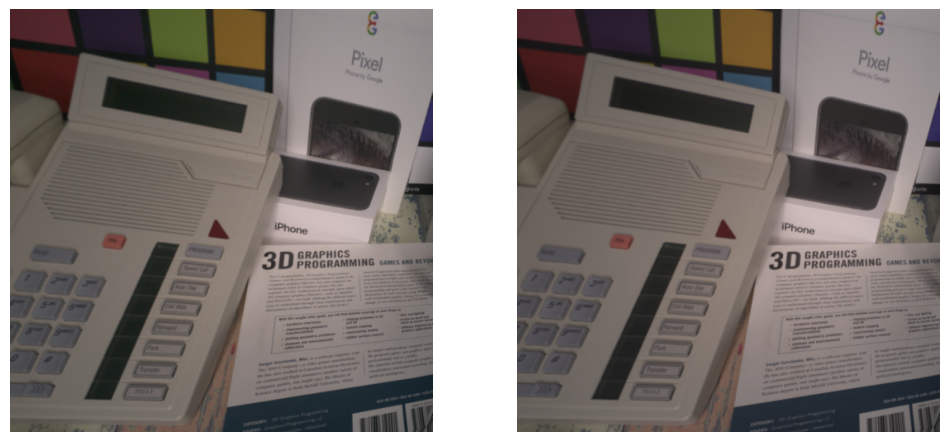

In [24]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

In [8]:
# Define recommended hyper-parameters
wd, loss_gen = 1e-3, MSELossFlat()
bbone = resnet34

In [13]:
# Create a generator learner
def create_gen_learner():
  return unet_learner(dls_gen, bbone, loss_func=loss_gen, blur=True, norm_type=NormType.Weight, self_attention=True)

In [29]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 187MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [30]:
# Fit model for a cycle
learn_gen.fit_one_cycle(2, wd=wd)

epoch,train_loss,valid_loss,time
0,0.089917,0.024797,00:40
1,0.015800,0.011271,00:38


In [31]:
# Unfreeze and learn more
learn_gen.unfreeze()

In [32]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.029504,0.021762,00:42
1,0.010986,0.010281,00:41
2,0.004844,0.004824,00:42


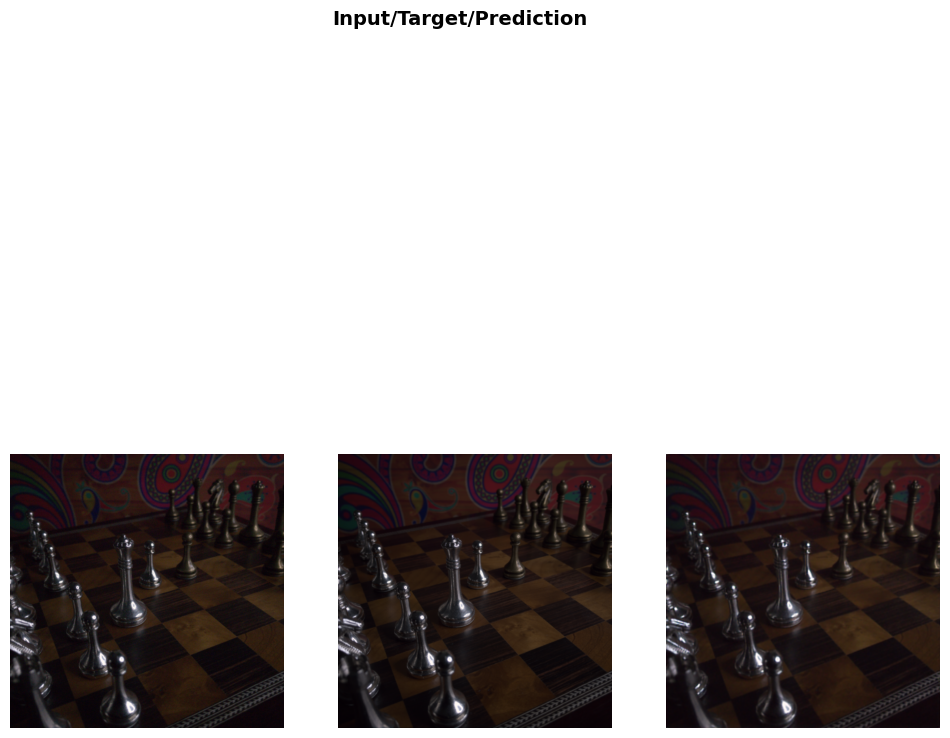

In [33]:
# Show results
learn_gen.show_results(max_n=4, figsize=(12,12))

In [34]:
learn_gen.save('gen-pre2')

Path('/content/SIDD_Small_sRGB_Only/Data/models/gen-pre2.pth')

## Save the generated images

Save generated images so they can be used for our `critic` (`discriminator`) model.

In [35]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [36]:
path_gen.mkdir(exist_ok=True)

In [37]:
def save_preds(dl, learn):
  "Save away predictions"
  names = dl.dataset.items

  preds,_ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
      dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
      arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
      Image.fromarray(arr).save(path_gen/names[i].name)

In [38]:
# Get rid of any augmentation, drop_last, and shuffle from our training DataLoader
dl = dls_gen.train.new(shuffle=False, drop_last=False,
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [39]:
# Get predictions and display
preds, _ = learn_gen.get_preds(dl=dl)
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]
arr = dec.numpy().transpose(1,2,0)
plt.imshow(arr.astype(np.uint8))

# Save preds
save_preds(dl, learn_gen)

## Training the critic

In [48]:
# We have to do this because of a bug for right now
path_g = get_image_files(path/name_gen)
path_i = get_image_files(path/'gt')
fnames = path_g + path_i

In [50]:
# Dataloader for the critic
def get_crit_dls(fnames, bs:int, size:int):
  "Generate two `Critic` DataLoaders"
  splits = RandomSplitter(0.1)(fnames)
  dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
  tfms = [ToTensor(), Resize(size)]
  gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
  return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

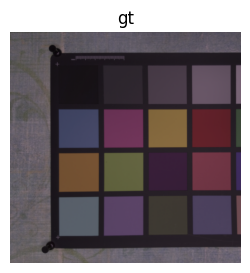

In [52]:
dls_crit = get_crit_dls(fnames, bs=BATCH_SIZE, size=IMAGE_SIZE)
dls_crit.show_batch()

In [53]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [54]:
def create_crit_learner(dls, metrics):
  return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [55]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [56]:
# Fit the critic using the images from pre-trained gen
learn_crit.fit_one_cycle(6, 1e-3, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.699363,0.674843,0.642857,02:34
1,0.697396,0.684663,0.642857,02:33
2,0.697818,0.680471,0.642857,02:32
3,0.693248,0.679517,0.642857,02:33
4,0.689876,0.673826,0.642857,02:32
5,0.686658,0.675303,0.642857,02:33


In [57]:
learn_crit.save('critic-pre2')

Path('models/critic-pre2.pth')

## The GAN

Now combine the two models together into a GAN

In [58]:
# Create dataloaders for critic
ls_crit = get_crit_dls(fnames, bs=BATCH_SIZE, size=IMAGE_SIZE)

# Create learner objects
learn_crit = create_crit_learner(dls_crit, metrics=True).load('critic-pre2')
learn_gen = create_gen_learner().load('gen-pre2')

In [61]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training:
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [62]:
# Define switcher, GAN learner, and learning rate
switcher = AdaptiveGANSwitcher()
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))
lr = 1e-4

In [65]:
learn.fit(10, lr, wd=wd)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,0.828277,1.006199,1.006199,0.695341,02:15
1,0.835398,1.006199,1.006199,0.695620,02:15
2,0.820850,1.006199,1.006199,0.695295,02:15
3,0.826944,1.006199,1.006199,0.695461,02:15
4,0.814518,1.006199,1.006199,0.696721,02:15
5,0.823300,1.006199,1.006199,0.695774,02:15
6,0.834984,1.006199,1.006199,0.695871,02:15
7,0.857321,1.006199,1.006199,0.694474,02:15
8,0.832819,1.006199,1.006199,0.694757,02:15
9,0.828887,1.006199,1.006199,0.695335,02:15


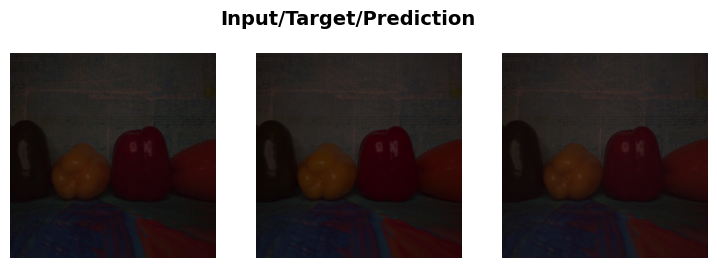

In [66]:
learn.show_results(max_n=4)

## Evaluation

In [11]:
# Mount content from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
# Create an eval dataloader
dls_gen_eval = get_dls(BATCH_SIZE, IMAGE_SIZE)

def create_gen_learner():
  return unet_learner(dls_gen_eval, bbone, loss_func=loss_gen, blur=True, norm_type=NormType.Weight, self_attention=True)

# Load the model
trained_gan = create_gen_learner().load('/content/drive/MyDrive/AIPI 590: Computer Vision/sidd-fastai-noisy-new/models/gen-pre2')

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


<class 'fastai.data.core.TfmdDL'>


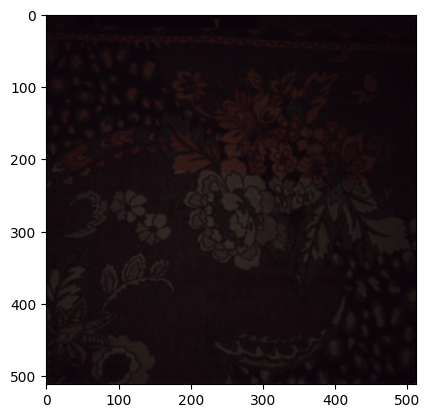

In [86]:
# Create the dataloader
dl = dls_gen_eval.valid.new(shuffle=False, drop_last=False,
                        after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

# Generate predictions from trained GAN
preds, _ = trained_gan.get_preds(dl=dl)
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]
arr = dec.numpy().transpose(1,2,0)
plt.imshow(arr.astype(np.uint8))

In [57]:
# Function to compute PSNR
def calculate_psnr(true_image, denoised_image):
    mse = np.mean((true_image - denoised_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

# Function to compute SSIM
def calculate_ssim(true_image, denoised_image):
    ssim_value = ssim(true_image, denoised_image, channel_axis=2)
    return ssim_value

def postprocess_tensor(image_tensor):
    # Denormalize using the mean and std used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_tensor = image_tensor.detach().squeeze(0)  # Remove batch dimension
    image_np = image_tensor.numpy().transpose((1, 2, 0))  # Convert to (H, W, C)
    image_np = std * image_np + mean  # Denormalize
    image_np = np.clip(image_np, 0, 1)  # Ensure values are within [0, 1]
    image_np = (image_np * 255).astype(np.uint8)  # Convert to [0, 255] uint8
    return image_np

def display_images_and_calc_metrics(noisy_image, denoised_image, true_image, display=True):
    # Display the images
    if display:
      fig, axs = plt.subplots(1, 3, figsize=(15, 5))
      axs[0].imshow(noisy_image)
      axs[0].set_title('Noisy Image')
      axs[0].axis('off')

      axs[1].imshow(denoised_image)
      axs[1].set_title('Denoised Image')
      axs[1].axis('off')

      axs[2].imshow(true_image)
      axs[2].set_title('True Image')
      axs[2].axis('off')

      plt.show()

    # Calculate and print metrics
    # Ensure images are numpy arrays for metric calculations
    true_image_np = np.array(true_image)
    denoised_image_np = np.array(denoised_image)
    noisy_image_np = np.array(noisy_image)

    psnr_value = calculate_psnr(true_image_np, noisy_image_np)
    ssim_value = calculate_ssim(true_image, noisy_image)
    print(f"Noisy PSNR: {psnr_value:.2f}")
    print(f"Noisy SSIM: {ssim_value:.4f}")
    denoised_psnr = calculate_psnr(true_image_np, denoised_image_np)
    denoised_ssim = calculate_ssim(true_image_np, denoised_image_np)
    print(f"Gen PSNR: {denoised_psnr}")
    print(f"Gen SSIM: {denoised_ssim}")

    return psnr_value, ssim_value, denoised_psnr, denoised_ssim

In [87]:
psnr_input = []
ssim_input = []
psnr_output = []
ssim_output = []

for batch_no, (noisy, gt) in enumerate(dl):
    if batch_no >= 32:
        break

    # Generate denoised image
    gen_image = postprocess_tensor(preds[batch_no])

    # Convert true image to numpy array
    gt_np = np.array(gt)
    # Resize the ground truth image to match denoised
    gt_image = postprocess_tensor(gt)

    # Convert noisy to numpy array
    noisy_np = np.array(noisy)
    # Resize noisy to match denoised
    noisy_image = postprocess_tensor(noisy)

    # Display the images and calculate metrics
    psnr_in, ssim_in, psnr_out, ssim_out = display_images_and_calc_metrics(noisy_image, gen_image, gt_image, display=False)

    # Append evaluation metrics
    psnr_input.append(psnr_in)
    ssim_input.append(ssim_in)
    psnr_output.append(psnr_out)
    ssim_output.append(ssim_out)

# average the lists
avg_psnr_input = sum(psnr_input) / len(psnr_input)
avg_ssim_input = sum(ssim_input) / len(ssim_input)
avg_psnr_output = sum(psnr_output) / len(psnr_output)
avg_ssim_output = sum(ssim_output) / len(ssim_output)

# Print Averages
print(f"Average PSNR Input: {avg_psnr_input:.2f}")
print(f"Average SSIM Input: {avg_ssim_input:.4f}")
print(f"Average PSNR Output: {avg_psnr_output:.2f}")
print(f"Average SSIM Output: {avg_ssim_output:.4f}")

Noisy PSNR: 38.81
Noisy SSIM: 0.9145
Gen PSNR: 37.76013663180813
Gen SSIM: 0.9233961169137261
Noisy PSNR: 41.30
Noisy SSIM: 0.9631
Gen PSNR: 38.77497303377617
Gen SSIM: 0.9647913235836828
Noisy PSNR: 35.33
Noisy SSIM: 0.8637
Gen PSNR: 39.69453278185385
Gen SSIM: 0.9595006869208517
Noisy PSNR: 40.38
Noisy SSIM: 0.9616
Gen PSNR: 39.040100412926506
Gen SSIM: 0.9714131504103793
Noisy PSNR: 43.74
Noisy SSIM: 0.9697
Gen PSNR: 40.39911581448446
Gen SSIM: 0.9736485174216699
Noisy PSNR: 42.35
Noisy SSIM: 0.9713
Gen PSNR: 37.926148807944074
Gen SSIM: 0.969883292357837
Noisy PSNR: 42.75
Noisy SSIM: 0.9805
Gen PSNR: 37.2637382041285
Gen SSIM: 0.9597636913584809
Noisy PSNR: 33.13
Noisy SSIM: 0.8551
Gen PSNR: 33.35954485815102
Gen SSIM: 0.916073813312544
Noisy PSNR: 38.29
Noisy SSIM: 0.9482
Gen PSNR: 37.301956089327845
Gen SSIM: 0.9533951786754568
Noisy PSNR: 38.31
Noisy SSIM: 0.9395
Gen PSNR: 37.2324577049579
Gen SSIM: 0.9640781588107984
Noisy PSNR: 38.04
Noisy SSIM: 0.9188
Gen PSNR: 37.46065273152